## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR 

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


## Setup

A clean and explicit setup ensures reproducibility: imports are centralised, the sample window is defined once, and display options are set for consistent outputs across machines.


In [2]:
# =========================
# Setup — Lecture 4
# =========================

import numpy as np
import pandas as pd
import requests

# Display options for clear tables in Colab
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

# Sample window (as requested)
START = "2021-01-01"
END   = "2024-12-31"

# BCRP series used in the lecture notebook
BCRP_CODES = ["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"]

print("Setup complete.")
print("Sample window:", START, "to", END)
print("BCRP series:", BCRP_CODES)


Setup complete.
Sample window: 2021-01-01 to 2024-12-31
BCRP series: ['PD04637PD', 'PD04639PD', 'PD04704XD', 'PD04701XD']


Constructing and printing the URL makes the data source **auditable** and the request **replicable**.  
The lecture uses the **BCRP Data API** by concatenating series codes with **hyphens (-)**.


In [3]:
# Build the BCRPData API URL
series_str = "-".join(BCRP_CODES)
bcrp_url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{series_str}/json/{START}/{END}/ing"

print("BCRPData API URL:")
print(bcrp_url)


BCRPData API URL:
https://estadisticas.bcrp.gob.pe/estadisticas/series/api/PD04637PD-PD04639PD-PD04704XD-PD04701XD/json/2021-01-01/2024-12-31/ing


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


Before reshaping into a wide time-series table, it is best practice to first organise the raw observations into a tidy (long) structure, where each row corresponds to one observation for one series on one date. This format is transparent, facilitates validation by series, and aligns with standard data-science conventions for clean data pipelines.

In [4]:
# --- Download data from the BCRP API ---
response = requests.get(bcrp_url, timeout=60)
response.raise_for_status()
payload = response.json()

# Inspect structure
print("Payload keys:", list(payload.keys()))

# Ensure periods exist and show first observation
assert "periods" in payload and len(payload["periods"]) > 0, "No periods returned. Check URL or date range."

print("Number of periods:", len(payload["periods"]))
print("First period dict:", payload["periods"][0])
print("First 5 raw dates:", [p["name"] for p in payload["periods"][:5]])

Payload keys: ['config', 'periods']
Number of periods: 1043
First period dict: {'name': '04.Jan.21', 'values': ['3.624', '3.624', '359.177118159863', '1943.2']}
First 5 raw dates: ['04.Jan.21', '05.Jan.21', '06.Jan.21', '07.Jan.21', '08.Jan.21']


In [5]:
rows = []
for obs in payload["periods"]:
    date_raw = str(obs["name"])
    vals = obs["values"]

    # Defensive date cleaning:
    # - remove time suffix if present (e.g., "2021-01-04T00:00:00")
    # - strip spaces
    date_clean = date_raw.split("T")[0].strip()

    for code, val in zip(BCRP_CODES, vals):
        rows.append((date_raw, date_clean, code, val))

peru_tidy = pd.DataFrame(rows, columns=["date_raw", "date_clean", "series", "value_raw"])

# Robust date parsing: do NOT force a single format, because your API output may vary
peru_tidy["date"] = pd.to_datetime(peru_tidy["date_clean"], errors="coerce")

# Robust numeric parsing
peru_tidy["value"] = (
    peru_tidy["value_raw"]
    .astype(str)
    .str.replace(",", ".", regex=False)
)
peru_tidy["value"] = pd.to_numeric(peru_tidy["value"], errors="coerce")

# IMPORTANT: check parsing success BEFORE dropping
print("Rows before dropping NaT:", len(peru_tidy))
print("Unparsed dates (NaT):", peru_tidy["date"].isna().sum())

# Now clean and keep the required tidy columns
peru_tidy = (
    peru_tidy
    .dropna(subset=["date"])
    .sort_values(["date", "series"])
    .reset_index(drop=True)
)[["date", "series", "value"]]

# Guaranteed print (works even if display fails)
print("\nTidy table preview (first 12 rows):")
print(peru_tidy.head(12).to_string(index=False))

print("\nTidy table shape:", peru_tidy.shape)
print("Series present:", peru_tidy["series"].unique())


C:\Users\crpac\AppData\Local\Temp\ipykernel_6288\2888885512.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  peru_tidy["date"] = pd.to_datetime(peru_tidy["date_clean"], errors="coerce")


Rows before dropping NaT: 4172
Unparsed dates (NaT): 344

Tidy table preview (first 12 rows):
      date    series       value
2021-01-01 PD04637PD         NaN
2021-01-01 PD04639PD         NaN
2021-01-01 PD04701XD 1891.100000
2021-01-01 PD04704XD  351.148537
2021-01-04 PD04637PD    3.624000
2021-01-04 PD04639PD    3.624000
2021-01-04 PD04701XD 1943.200000
2021-01-04 PD04704XD  359.177118
2021-01-05 PD04637PD    3.627500
2021-01-05 PD04639PD    3.627000
2021-01-05 PD04701XD 1940.350000
2021-01-05 PD04704XD  358.973002

Tidy table shape: (3828, 3)
Series present: ['PD04637PD' 'PD04639PD' 'PD04701XD' 'PD04704XD']


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


A wide-format table is the standard representation for time-series analysis: it stores one observation per date and one column per variable. This structure facilitates direct comparisons across series, straightforward merging with US asset returns, and transparent econometric modelling. The cleaning step consists of mapping raw BCRP codes to semantically meaningful column names and reshaping the tidy dataset via a pivot operation.

In [6]:
# --- Map BCRP codes to the lecture notebook variable names ---
code_to_name = {
    "PD04637PD": "fx_interbank",
    "PD04639PD": "fx_sbs",
    "PD04704XD": "gold",
    "PD04701XD": "copper",
}

# Defensive check: confirm all codes are present before reshaping
missing = set(code_to_name.keys()) - set(peru_tidy["series"].unique())
assert not missing, f"Missing expected series in peru_tidy: {missing}"

# --- Reshape from tidy (long) to wide (time-series) format ---
peru_wide = (
    peru_tidy
    .assign(series=lambda d: d["series"].map(code_to_name))
    .pivot_table(index="date", columns="series", values="value", aggfunc="last")
    .sort_index()
    .reset_index()
)

# Ensure the column order matches the notebook requirement exactly
peru_wide = peru_wide[["date", "fx_interbank", "fx_sbs", "gold", "copper"]]

# Quick inspection
print("Wide table preview:")
print(peru_wide.head(10).to_string(index=False))

print("\nWide table shape:", peru_wide.shape)
print("Columns:", list(peru_wide.columns))

Wide table preview:
      date  fx_interbank  fx_sbs       gold  copper
2021-01-01           NaN     NaN 351.148537 1891.10
2021-01-04      3.624000   3.624 359.177118 1943.20
2021-01-05      3.627500   3.627 358.973002 1940.35
2021-01-06      3.624833   3.625 368.747917 1931.95
2021-01-07      3.620667   3.620 364.529508 1920.10
2021-01-08      3.611000   3.610 369.496345 1862.90
2021-01-11      3.615167   3.615 360.673973 1847.25
2021-01-12      3.606333   3.606 362.102789 1841.25
2021-01-13      3.612500   3.610 361.082206 1858.85
2021-01-14      3.610667   3.610 362.987294 1841.75

Wide table shape: (957, 5)
Columns: ['date', 'fx_interbank', 'fx_sbs', 'gold', 'copper']


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


US financial assets are retrieved using Yahoo Finance via the yfinance package, which is widely adopted in empirical finance for obtaining daily market data. Adjusted prices are used to ensure that the resulting series account for dividends and stock splits, thereby making subsequent return calculations economically meaningful. The data are organised in a tidy (long) format, with one observation per asset and date, which is consistent with best practices for financial time-series analysis.

In [7]:
import yfinance as yf
import pandas as pd

USA_TICKERS = ["SPY", "TLT", "GLD"]

yf_data = yf.download(
    tickers=USA_TICKERS,
    start=START,
    end=END,
    auto_adjust=True,
    progress=False
)

print("Empty?", yf_data.empty)
print("Columns names:", getattr(yf_data.columns, "names", None))
print("Columns sample:", list(yf_data.columns)[:5])

# --- Handle MultiIndex with order (Price, Ticker) ---
if isinstance(yf_data.columns, pd.MultiIndex):
    # Your case: level 0 is Price field, level 1 is Ticker
    lvl0 = yf_data.columns.get_level_values(0)
    lvl1 = yf_data.columns.get_level_values(1)

    if "Close" in set(lvl0):
        close_wide = yf_data["Close"].copy()     # columns become tickers
    elif "close" in set(lvl0):
        close_wide = yf_data["close"].copy()
    else:
        raise KeyError(f"No Close field in level 0. Found level0 fields: {sorted(set(lvl0))}")

    usa_tidy = (
        close_wide
        .reset_index()
        .melt(id_vars="Date", var_name="ticker", value_name="close")
        .rename(columns={"Date": "date"})
    )

else:
    # Single-index fallback
    if "Close" in yf_data.columns:
        usa_tidy = yf_data[["Close"]].rename(columns={"Close": "close"}).reset_index()
    elif "close" in yf_data.columns:
        usa_tidy = yf_data[["close"]].rename(columns={"close": "close"}).reset_index()
    else:
        raise KeyError(f"No Close column found. Columns: {list(yf_data.columns)}")

    usa_tidy = usa_tidy.rename(columns={"Date": "date"})
    usa_tidy["ticker"] = USA_TICKERS[0]
    usa_tidy = usa_tidy[["date", "ticker", "close"]]

# Clean types and order
usa_tidy["date"] = pd.to_datetime(usa_tidy["date"])
usa_tidy["close"] = pd.to_numeric(usa_tidy["close"], errors="coerce")
usa_tidy = (
    usa_tidy
    .dropna(subset=["close"])
    .sort_values(["date", "ticker"])
    .reset_index(drop=True)
)[["date", "ticker", "close"]]

print("\nUS assets (tidy) — preview:")
print(usa_tidy.head(12).to_string(index=False))

print("\nTidy shape:", usa_tidy.shape)
print("Tickers present:", usa_tidy["ticker"].unique())

Empty? False
Columns names: ['Price', 'Ticker']
Columns sample: [('Close', 'GLD'), ('Close', 'SPY'), ('Close', 'TLT'), ('High', 'GLD'), ('High', 'SPY')]

US assets (tidy) — preview:
      date ticker      close
2021-01-04    GLD 182.330002
2021-01-04    SPY 344.256714
2021-01-04    TLT 134.713730
2021-01-05    GLD 182.869995
2021-01-05    SPY 346.627777
2021-01-05    TLT 133.713211
2021-01-06    GLD 179.899994
2021-01-06    SPY 348.700104
2021-01-06    TLT 130.968323
2021-01-07    GLD 179.479996
2021-01-07    SPY 353.880920
2021-01-07    TLT 129.813919

Tidy shape: (3012, 3)
Tickers present: ['GLD' 'SPY' 'TLT']


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.  


Daily returns are computed as percentage changes in adjusted closing prices, which is the standard transformation in empirical finance for analysing asset performance and risk. Returns are calculated by ticker to ensure that observations are not incorrectly mixed across assets. After computing returns, it is essential to validate that no infinite values are present, as these may arise from zero prices or data glitches and would invalidate subsequent statistical analysis.

In [8]:
# --- Compute daily returns by ticker ---
usa_returns = usa_tidy.copy()

usa_returns["ret"] = (
    usa_returns
    .groupby("ticker")["close"]
    .pct_change()
)

# --- Validate: check for infinite values ---
has_inf = np.isinf(usa_returns["ret"]).any()
print("Any infinite return values?", has_inf)

# Replace infinite values with NaN (defensive cleaning)
usa_returns.loc[np.isinf(usa_returns["ret"]), "ret"] = np.nan

# Final check
assert not np.isinf(usa_returns["ret"]).any(), "Infinite values still present in returns!"

# Preview
print("\nUS assets with returns — preview:")
print(
    usa_returns
    .head(12)
    .to_string(index=False)
)

Any infinite return values? False

US assets with returns — preview:
      date ticker      close       ret
2021-01-04    GLD 182.330002       NaN
2021-01-04    SPY 344.256714       NaN
2021-01-04    TLT 134.713730       NaN
2021-01-05    GLD 182.869995  0.002962
2021-01-05    SPY 346.627777  0.006887
2021-01-05    TLT 133.713211 -0.007427
2021-01-06    GLD 179.899994 -0.016241
2021-01-06    SPY 348.700104  0.005979
2021-01-06    TLT 130.968323 -0.020528
2021-01-07    GLD 179.479996 -0.002335
2021-01-07    SPY 353.880920  0.014858
2021-01-07    TLT 129.813919 -0.008814


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


Comparing exchange rate levels (rather than returns) allows us to assess whether alternative official FX measures move consistently over time. In the Peruvian case, the interbank exchange rate and the SBS exchange rate are expected to track each other closely, as both reflect transactions in the same underlying FX market but may differ slightly due to institutional coverage and reporting conventions.

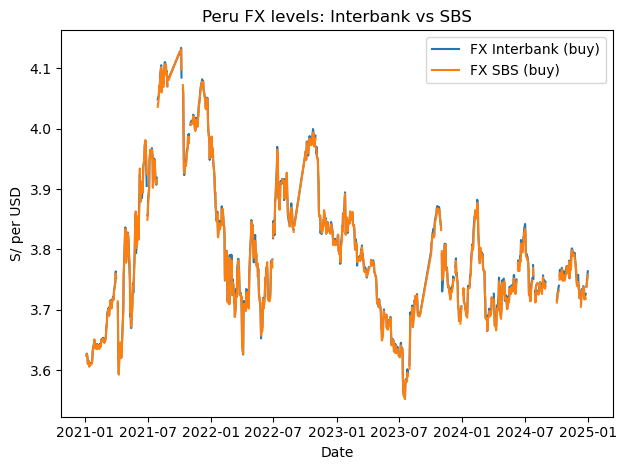

In [9]:
import matplotlib.pyplot as plt

# --- FX levels plot ---
plt.figure()
plt.plot(peru_wide["date"], peru_wide["fx_interbank"], label="FX Interbank (buy)")
plt.plot(peru_wide["date"], peru_wide["fx_sbs"], label="FX SBS (buy)")

plt.title("Peru FX levels: Interbank vs SBS")
plt.xlabel("Date")
plt.ylabel("S/ per USD")
plt.legend()
plt.tight_layout()
plt.show()


## Short comment
Interbank and SBS exchange rate series move almost identically over the sample period, indicating a high degree of consistency across official FX measures in Peru. Minor and transitory differences are observed, which likely reflect institutional reporting practices rather than economically meaningful deviations. Overall, the close co-movement confirms that both series capture the same underlying exchange rate dynamics.

7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  
The share of positive-return days provides a non-parametric measure of asset performance that focuses on the frequency of gains rather than their magnitude. Unlike the mean return, this statistic is robust to outliers and offers complementary insight into the persistence of positive daily performance across assets.

In [10]:
# --- Share of positive-return days by ticker ---
positive_share = (
    usa_returns
    .dropna(subset=["ret"])
    .groupby("ticker")["ret"]
    .apply(lambda x: (x > 0).mean())
    .rename("share_positive_days")
)

# Display result
print("Share of positive-return days by ticker:")
print(positive_share.to_string())


Share of positive-return days by ticker:
ticker
GLD    0.520439
SPY    0.541376
TLT    0.484546


## Academic note
The proportion of positive-return days is computed for each US asset as the fraction of trading days with strictly positive daily returns. This measure captures asymmetries in daily performance and complements traditional moment-based statistics by focusing on the sign rather than the size of returns.

8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  
A bar chart provides a clear visual comparison of the frequency of positive-return days across assets. Adding numerical annotations above each bar improves interpretability by allowing the reader to immediately identify exact proportions without referring to axis scales, which is consistent with good practice in data visualisation for empirical finance.

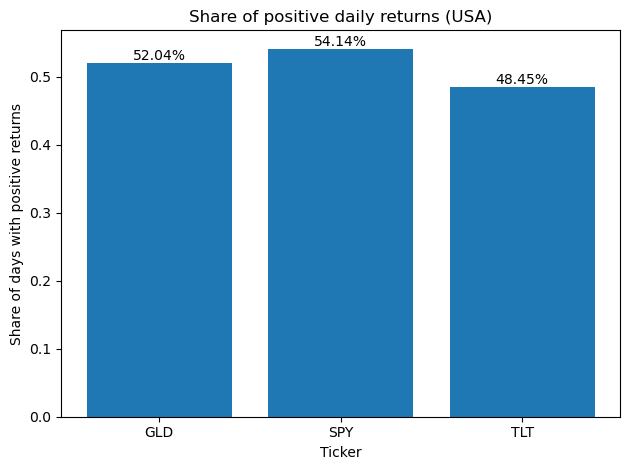

In [11]:
import matplotlib.pyplot as plt

# --- Bar chart of positive-return shares ---
plt.figure()
bars = plt.bar(
    positive_share.index,
    positive_share.values
)

plt.title("Share of positive daily returns (USA)")
plt.xlabel("Ticker")
plt.ylabel("Share of days with positive returns")

# --- Add annotations above each bar ---
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2%}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

## Academic note
The bar chart highlights differences in the proportion of positive-return days across US assets. Annotating each bar with its exact value enhances readability and facilitates direct comparison, complementing the numerical summary presented earlier.

9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  
Histograms are a standard tool for comparing empirical distributions, as they reveal differences in dispersion, skewness, and concentration of observations. Comparing the distribution of Peruvian gold prices (London spot) with the GLD ETF allows us to assess whether the financial representation of gold exhibits similar distributional properties to the underlying commodity price, acknowledging that the two series are expressed in different units and scales.

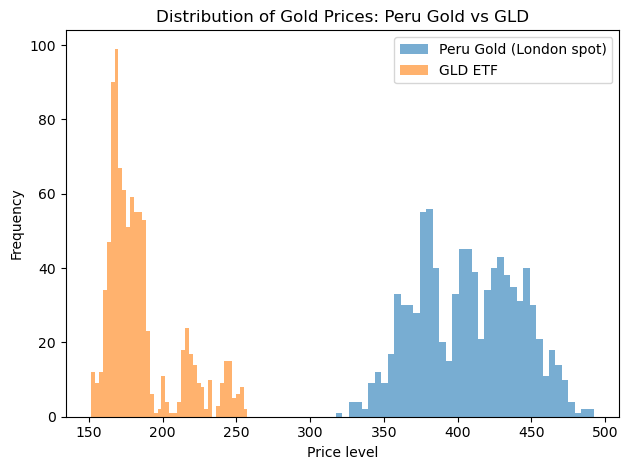

In [13]:
import matplotlib.pyplot as plt

# --- Prepare gold series from Peru and GLD ---
peru_gold = (
    peru_wide[["date", "gold"]]
    .dropna()
)

gld_prices = (
    usa_returns
    .loc[usa_returns["ticker"] == "GLD", ["date", "close"]]
    .rename(columns={"close": "gld"})
    .dropna()
)

# Align by date to ensure comparability
gold_compare = (
    peru_gold
    .merge(gld_prices, on="date", how="inner")
)

# --- Histogram comparison ---
plt.figure()
plt.hist(
    gold_compare["gold"],
    bins=40,
    alpha=0.6,
    label="Peru Gold (London spot)"
)
plt.hist(
    gold_compare["gld"],
    bins=40,
    alpha=0.6,
    label="GLD ETF"
)

plt.title("Distribution of Gold Prices: Peru Gold vs GLD")
plt.xlabel("Price level")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

## Academic note
The histogram comparison shows that, despite differences in scale, the distributions of Peruvian gold prices and the GLD ETF exhibit broadly similar shapes. This reflects the fact that GLD closely tracks the underlying gold market, although financial frictions and ETF-specific features may introduce small distributional differences.

10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  
While histograms summarise distributions through bins (and are therefore sensitive to bin choice), the Empirical Cumulative Distribution Function (ECDF) provides a bin-free representation of the entire distribution. The ECDF is particularly useful for comparing percentiles and tail behaviour, which are central to risk analysis.

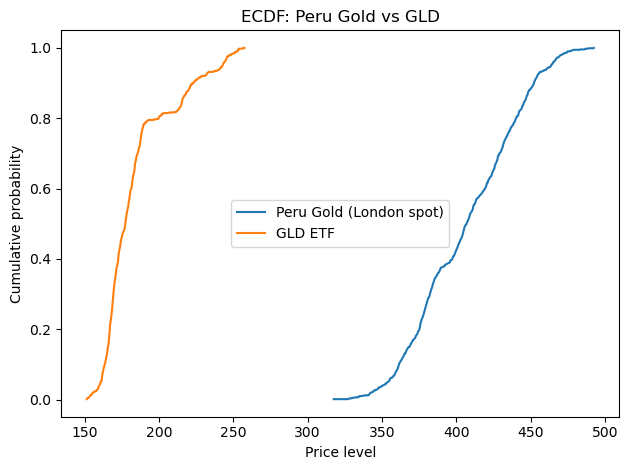

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# --- Build ECDFs ---
ecdf_peru_gold = ECDF(gold_compare["gold"])
ecdf_gld = ECDF(gold_compare["gld"])

# Grid for plotting
x_peru = np.linspace(gold_compare["gold"].min(), gold_compare["gold"].max(), 400)
x_gld  = np.linspace(gold_compare["gld"].min(),  gold_compare["gld"].max(),  400)

# --- ECDF plot ---
plt.figure()
plt.plot(x_peru, ecdf_peru_gold(x_peru), label="Peru Gold (London spot)")
plt.plot(x_gld,  ecdf_gld(x_gld),        label="GLD ETF")

plt.title("ECDF: Peru Gold vs GLD")
plt.xlabel("Price level")
plt.ylabel("Cumulative probability")
plt.legend()
plt.tight_layout()
plt.show()


## Comment: ECDF vs Histogram
Relative to the histogram, the ECDF provides a smoother and bin-independent comparison of the two distributions. It allows for a direct assessment of percentile differences and tail behaviour, which are less transparent in histograms. While the histogram highlights the overall shape and dispersion, the ECDF makes it easier to evaluate distributional dominance and to compare quantiles across the two gold series.

11. *(Relationships)* Build `FX_change` and relate it to `SPY_ret` (scatter plot).  


12. Compute the **correlation** between `FX_change` and `SPY_ret` and explain the sign.  


13. Estimate a simple regression `FX_change ~ SPY_ret` and interpret the coefficient.  


14. *(Pandas)* Do a selection exercise: `.iloc` (position-based) vs conditional filtering.  


15. Create missing data on purpose in one series and apply imputation (as in the notebook).  


16. Standardize a variable (z-score) and plot **before vs after**.  


17. Find the day with the largest `|SPY_ret|` and **annotate it** in the returns plot (like the exercise).  


18. Save one figure into `/figures` using `savefig` and verify the file exists.  


19. Build a **summary stats table** for returns (mean, sd, p5, p95, etc.).  


20. Compute **historical 95% VaR** for a **60/40 portfolio (SPY/TLT)** and explain what it means.
